In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try: 
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda, Permute, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import applications, losses, optimizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.python.framework import ops
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar100
from keras.engine import training
from keras.utils import plot_model
from tensorflow.keras import regularizers

print(tf.__version__)

2.1.0


Using TensorFlow backend.


In [0]:
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob 
from numpy import genfromtxt
import pandas as pd

In [0]:
def load_data() -> Tuple[np.ndarray, np.ndarray, 
                          np.ndarray, np.ndarray]:
    (x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    return x_train, x_test, y_train, y_test

In [0]:
x_train, x_test, y_train, y_test = load_data()
print('x_train shape: {} | y_train shape: {}\nx_test shape : {} | y_test shape : {}'.format(x_train.shape, y_train.shape, 
x_test.shape, y_test.shape))
y_train_label = to_categorical(y_train, num_classes=100)
y_test_label = to_categorical(y_test, num_classes=100)

x_train shape: (50000, 32, 32, 3) | y_train shape: (50000, 1)
x_test shape : (10000, 32, 32, 3) | y_test shape : (10000, 1)


In [0]:
# define constants
batch_size = 128
epoch_max = 75
# CIFAR-10 constants
img_size = 32
img_channels = 3
num_classes = 100
steps_per_epoch = int(x_train.shape[0] / batch_size)
l2_norm = regularizers.l2(0.000025)

filepath='keras_model_conv2D'

In [0]:
input_shape = x_train[0,:,:,:].shape
model_input = tf.keras.layers.Input(shape=input_shape)

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps_per_epoch * 1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

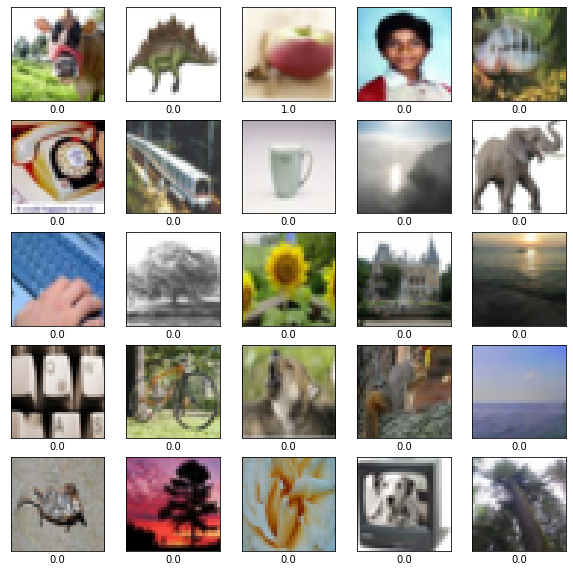

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(y_train_label[i][0])
plt.show()

In [0]:
def plot_validation_history(model, hist, plt_path):
  # Plot training & validation accuracy values
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  #plot_model(model, to_file= plt_path)

In [0]:
early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=7, verbose=1)

ckpt_callback = ModelCheckpoint(filepath,
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

def evaluate(model, hist, plt_path):
    score = model.evaluate(x_test, y_test_label, verbose=0)
    print('Test loss: %.3f' % score[0])
    print('> Test accuracy: %.3f' % (score[1] * 100.0))

In [0]:
def compile_with_train_generator(model: training.Model, num_epochs: int, batch_size: int) -> Tuple [History, str]:
  adam_opt = get_optimizer()
  model.compile(optimizer = adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
  
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range = 0.1) #, shear_range = 0.1
  # prepare iterator
  it_train = datagen.flow(x_train, y_train_label, batch_size=batch_size)
  # fit model
  steps = int(x_train.shape[0] / batch_size)
  history = model.fit_generator(it_train, steps_per_epoch=steps, epochs= num_epochs, validation_data=(x_test, y_test_label), callbacks=[early_stop], verbose=1)
  
  weight_files = "" #glob.glob(os.path.join(os.getcwd(), 'weights/*'))
  weight_file = "model" #max(weight_files, key=os.path.getctime) # most recent file
  return history, weight_file

In [0]:
def all_stack_cnn_filter_size4_strid2(model_input: Tensor) -> training.Model:
    x1 = Conv2D(32, kernel_size=(4, 4), activation='tanh', padding = 'same')(model_input)
    x1 = Conv2D(32, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform')(x1)
    x1 = Dropout(0.2) (x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(32, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform')(x1)

    x1 = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform')(x1)
    x1 = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform')(x1)
    x1 = Dropout(0.3) (x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(64, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform')(x1)

    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform')(x1)
    x = Dropout(0.4) (x)
    x = BatchNormalization()(x)
    
    x = Conv2D(100, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='all_stack_cnn_filter_size4_strid2')
    
    return model

In [0]:
batch_size = 128
num_epochs = 100
all_stack_cnn_filter_size4_strid2_model = all_stack_cnn_filter_size4_strid2(model_input)
isFile = os.path.isfile("all_stack_cnn_filter_size4_strid2.h5")
if isFile :
  all_stack_cnn_filter_size4_strid2_model.load_weights('all_stack_cnn_filter_size4_strid2.h5')
  
hist, conv_pool_cnn_weight_file = compile_with_train_generator(all_stack_cnn_filter_size4_strid2_model, num_epochs, batch_size)

evaluate(all_stack_cnn_filter_size4_strid2_model, hist, 'output/all_stack_cnn_filter_size4_strid2.png')
all_stack_cnn_filter_size4_strid2_model.save('all_stack_cnn_filter_size4_strid2.h5')

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 23s 59ms/step - loss: 1.3965 - accuracy: 0.6012 - val_loss: 1.7111 - val_accuracy: 0.5498
Epoch 2/100
390/390 [==============================] - 22s 57ms/step - loss: 1.3661 - accuracy: 0.6082 - val_loss: 1.9270 - val_accuracy: 0.5144
Epoch 3/100
390/390 [==============================] - 22s 56ms/step - loss: 1.3510 - accuracy: 0.6142 - val_loss: 1.6534 - val_accuracy: 0.5573
Epoch 4/100
390/390 [==============================] - 22s 58ms/step - loss: 1.3363 - accuracy: 0.6152 - val_loss: 1.6560 - val_accuracy: 0.5636
Epoch 5/100
390/390 [==============================] - 22s 56ms/step - loss: 1.3187 - accuracy: 0.6221 - val_loss: 1.6275 - val_accuracy: 0.5669
Epoch 6/100
390/390 [==============================] - 22s 57ms/step - loss: 1.3081 - accuracy: 0.6229 - val_loss: 1.7277 - val_accuracy: 0.5520
Epoch 7/100
390/390 [==============================] - 22s

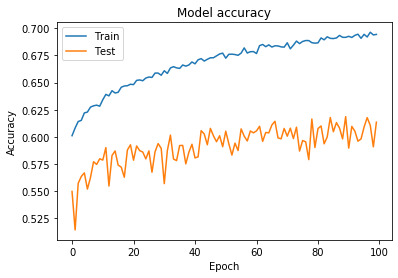

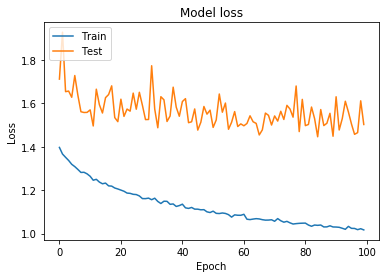

all_stack_cnn_filter_size4_strid2.h5  sample_data


In [0]:
plt_path = 'output/all_stack_cnn_filter_size4_strid2.png'
plot_validation_history(all_stack_cnn_filter_size4_strid2_model, hist, plt_path)
!ls

In [0]:
all_stack_cnn_filter_size4_strid2_model.summary()

Model: "all_stack_cnn_filter_size4_strid2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 32)        16416     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 32)        16416     
_________________________________________________________________
conv2d_43 (Conv2D)           (Non

In [0]:
def all_stack_cnn_diff_filter_size_strid2_inception(model_input: Tensor) -> training.Model:
    x = Conv2D(64, kernel_size=(4, 4), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(model_input)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.35) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)

    x2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', kernel_regularizer = l2_norm)(x)
    x2 = Conv2D(64, (3, 3), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x2)
    x2 = Dropout(0.35) (x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(64, (3, 3), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x2)

    x3 = Conv2D(64, kernel_size=(2, 2), activation='relu', padding = 'same')(x)
    x3 = Conv2D(64, (2, 2), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x3)
    x3 = Dropout(0.35) (x3)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(64, (2, 2), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x3)
    x3 = Dropout(0.4) (x3)

    x = layers.Add()([x2, x3])
    x = Conv2D(100, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='all_stack_cnn_diff_filter_size_strid2_inception')
    
    return model

In [0]:
batch_size = 128
num_epochs = 100
all_stack_cnn_diff_filter_size_strid2_inception_model = all_stack_cnn_diff_filter_size_strid2_inception(model_input)
isFile = os.path.isfile("all_stack_cnn_diff_filter_size_strid2_inception.h5")
if isFile :
  all_stack_cnn_diff_filter_size_strid2_inception_model.load_weights('all_stack_cnn_diff_filter_size_strid2_inception.h5')
hist, conv_pool_cnn_weight_file = compile_with_train_generator(all_stack_cnn_diff_filter_size_strid2_inception_model, num_epochs, batch_size)

all_stack_cnn_diff_filter_size_strid2_inception_model.save('all_stack_cnn_diff_filter_size_strid2_inception.h5')

evaluate(all_stack_cnn_diff_filter_size_strid2_inception_model, hist, 'output/all_stack_cnn_diff_filter_size_strid2_inception.png')


  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 25s 65ms/step - loss: 4.0532 - accuracy: 0.0951 - val_loss: 3.8396 - val_accuracy: 0.1346
Epoch 2/100
390/390 [==============================] - 24s 61ms/step - loss: 3.4757 - accuracy: 0.1877 - val_loss: 3.5753 - val_accuracy: 0.1789
Epoch 3/100
390/390 [==============================] - 24s 62ms/step - loss: 3.1338 - accuracy: 0.2488 - val_loss: 3.1107 - val_accuracy: 0.2503
Epoch 4/100
390/390 [==============================] - 24s 62ms/step - loss: 2.9009 - accuracy: 0.2930 - val_loss: 2.9013 - val_accuracy: 0.2880
Epoch 5/100
390/390 [==============================] - 24s 61ms/step - loss: 2.7211 - accuracy: 0.3305 - val_loss: 2.7115 - val_accuracy: 0.3324
Epoch 6/100
390/390 [==============================] - 24s 62ms/step - loss: 2.5842 - accuracy: 0.3575 - val_loss: 2.7053 - val_accuracy: 0.3414
Epoch 7/100
390/390 [==============================] - 24s

In [0]:
all_stack_cnn_diff_filter_size_strid2_inception_model.summary()

In [0]:
def all_stack_cnn_diff_filter_diff_size_strid2_inception(model_input: Tensor) -> training.Model:
    x = Conv2D(64, kernel_size=(4, 4), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(model_input)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.35) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)

    x2 = Conv2D(64, kernel_size=(4, 2), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(x)
    x2 = Conv2D(64, (3, 3), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x2)
    x2 = Dropout(0.35) (x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(64, (3, 3), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x2)

    x3 = Conv2D(64, kernel_size=(2, 4), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(x)
    x3 = Conv2D(64, (2, 2), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x3)
    x3 = Dropout(0.35) (x3)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(64, (2, 2), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x3)
    x3 = Dropout(0.4) (x3)

    x = layers.Add()([x2, x3])
    x = Conv2D(100, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='all_stack_cnn_diff_filter_diff_size_strid2_inception')
    
    return model

In [0]:
batch_size = 128
num_epochs = 50
all_stack_cnn_diff_filter_diff_size_strid2_inception_model = all_stack_cnn_diff_filter_diff_size_strid2_inception(model_input)

isFile = os.path.isfile("all_stack_cnn_diff_filter_diff_size_strid2_inception_model.h5")
if isFile :
  all_stack_cnn_diff_filter_diff_size_strid2_inception_model.load_weights('all_stack_cnn_diff_filter_diff_size_strid2_inception_model.h5')

hist, conv_pool_cnn_weight_file = compile_with_train_generator(all_stack_cnn_diff_filter_diff_size_strid2_inception_model, num_epochs, batch_size)

all_stack_cnn_diff_filter_diff_size_strid2_inception_model.save('all_stack_cnn_diff_filter_diff_size_strid2_inception_model.h5')

evaluate(all_stack_cnn_diff_filter_diff_size_strid2_inception_model, hist, 'output/all_stack_cnn_diff_filter_diff_size_strid2_inception.png')

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/50
390/390 [==============================] - 26s 66ms/step - loss: 1.7860 - accuracy: 0.5208 - val_loss: 1.9743 - val_accuracy: 0.4937
Epoch 2/50
390/390 [==============================] - 24s 62ms/step - loss: 1.7597 - accuracy: 0.5281 - val_loss: 1.9111 - val_accuracy: 0.5019
Epoch 3/50
390/390 [==============================] - 25s 63ms/step - loss: 1.7369 - accuracy: 0.5341 - val_loss: 2.0469 - val_accuracy: 0.4872
Epoch 4/50
390/390 [==============================] - 24s 62ms/step - loss: 1.7179 - accuracy: 0.5410 - val_loss: 2.0153 - val_accuracy: 0.4839
Epoch 5/50
390/390 [==============================] - 24s 62ms/step - loss: 1.7076 - accuracy: 0.5437 - val_loss: 1.9177 - val_accuracy: 0.5132
Epoch 6/50
390/390 [==============================] - 24s 62ms/step - loss: 1.6863 - accuracy: 0.5463 - val_loss: 1.9626 - val_accuracy: 0.4948
Epoch 7/50
390/390 [==============================] - 24s 61ms/s

In [0]:
def all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu(model_input: Tensor) -> training.Model:
    x1 = Conv2D(32, kernel_size=(4, 4), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(model_input)
    x1 = Conv2D(32, (4, 4), activation='relu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x1)
    x1 = Dropout(0.25) (x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(32, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x1)

    x2 = Conv2D(32, kernel_size=(1, 1), activation='relu', padding = 'same', strides = 2, kernel_regularizer = l2_norm)(model_input)
    x = layers.Add()([x1, x2])
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Conv2D(64, (4, 4), activation='relu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.3) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)

    x = Conv2D(64, (4, 4), activation='relu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.35) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (2, 2), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.4) (x)
    x = Conv2D(100, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu')
    
    return model

In [0]:
batch_size = 128
num_epochs = 50
all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model = all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu(model_input)
isFile = os.path.isfile("all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.h5")
if isFile :
  all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.load_weights('all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.h5')
hist, conv_pool_cnn_weight_file = compile_with_train_generator(all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model, num_epochs, batch_size)

all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.save('all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.h5')

evaluate(all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model, hist, 'output/all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.png')

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/50
390/390 [==============================] - 24s 61ms/step - loss: 1.7051 - accuracy: 0.5807 - val_loss: 1.7665 - val_accuracy: 0.5844
Epoch 2/50
390/390 [==============================] - 23s 58ms/step - loss: 1.6882 - accuracy: 0.5847 - val_loss: 1.8489 - val_accuracy: 0.5645
Epoch 3/50
390/390 [==============================] - 23s 58ms/step - loss: 1.6921 - accuracy: 0.5854 - val_loss: 1.8468 - val_accuracy: 0.5628
Epoch 4/50
390/390 [==============================] - 23s 59ms/step - loss: 1.6844 - accuracy: 0.5848 - val_loss: 1.9084 - val_accuracy: 0.5564
Epoch 5/50
390/390 [==============================] - 22s 56ms/step - loss: 1.7022 - accuracy: 0.5817 - val_loss: 1.9113 - val_accuracy: 0.5514
Epoch 6/50
390/390 [==============================] - 22s 57ms/step - loss: 1.6873 - accuracy: 0.5857 - val_loss: 1.8649 - val_accuracy: 0.5577
Epoch 7/50
390/390 [==============================] - 22s 57ms/s

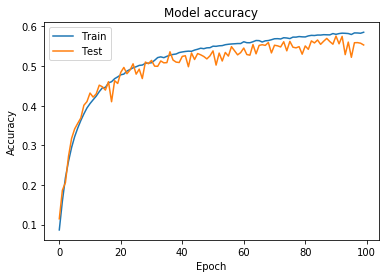

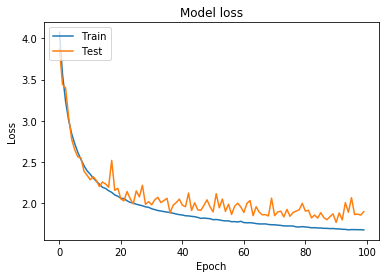

all_stack_cnn_diff_filter_size_strid2_inception.h5
all_stack_cnn_filter_size4_strid2.h5
all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.h5
sample_data


In [0]:
plt_path = 'output/all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model.png'
plot_validation_history(all_stack_cnn_filter_size4_strid2_resnet_with_alt_elu_relu_model, hist, plt_path)
!ls

In [0]:
all_stack_cnn_filter_size4_strid2_resnet.summary()

In [0]:
def all_stack_cnn_filter_size4_strid2_resnet(model_input: Tensor) -> training.Model:
    x1 = Conv2D(32, kernel_size=(4, 4), activation='elu', padding = 'same', kernel_regularizer = l2_norm)(model_input)
    x1 = Conv2D(32, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x1)
    x1 = Dropout(0.25) (x1)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(32, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x1)

    x2 = Conv2D(32, kernel_size=(1, 1), activation='elu', padding = 'same', strides = 2, kernel_regularizer = l2_norm)(model_input)
    x = layers.Add()([x1, x2])
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.3) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)

    x = Conv2D(64, (4, 4), activation='elu', padding = 'same', kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.35) (x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (2, 2), activation='elu', padding = 'same', strides = 2, kernel_initializer='he_uniform', kernel_regularizer = l2_norm)(x)
    x = Dropout(0.4) (x)
    x = Conv2D(100, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)

    model = Model(model_input, x, name='all_stack_cnn_filter_size4_strid2_resnet')
    
    return model

In [0]:
batch_size = 128
num_epochs = 50
all_stack_cnn_filter_size4_strid2_resnet_model = all_stack_cnn_filter_size4_strid2_resnet(model_input)
isFile = os.path.isfile("all_stack_cnn_filter_size4_strid2_resnet_model.h5")
if isFile :
  all_stack_cnn_filter_size4_strid2_resnet_model.load_weights('all_stack_cnn_filter_size4_strid2_resnet_model.h5')
hist, conv_pool_cnn_weight_file = compile_with_train_generator(all_stack_cnn_filter_size4_strid2_resnet_model, num_epochs, batch_size)

all_stack_cnn_filter_size4_strid2_resnet_model.save('all_stack_cnn_filter_size4_strid2_resnet_model.h5')

evaluate(all_stack_cnn_filter_size4_strid2_resnet_model, hist, 'output/all_stack_cnn_filter_size4_strid2_resnet.png')

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/50
390/390 [==============================] - 24s 60ms/step - loss: 2.2560 - accuracy: 0.4126 - val_loss: 2.2896 - val_accuracy: 0.4115
Epoch 2/50
390/390 [==============================] - 22s 57ms/step - loss: 2.2134 - accuracy: 0.4236 - val_loss: 2.1916 - val_accuracy: 0.4309
Epoch 3/50
390/390 [==============================] - 22s 57ms/step - loss: 2.1715 - accuracy: 0.4326 - val_loss: 2.2903 - val_accuracy: 0.4191
Epoch 4/50
390/390 [==============================] - 22s 57ms/step - loss: 2.1337 - accuracy: 0.4429 - val_loss: 2.1521 - val_accuracy: 0.4486
Epoch 5/50
390/390 [==============================] - 23s 58ms/step - loss: 2.1057 - accuracy: 0.4472 - val_loss: 2.0366 - val_accuracy: 0.4682
Epoch 6/50
390/390 [==============================] - 22s 56ms/step - loss: 2.0747 - accuracy: 0.4556 - val_loss: 2.0533 - val_accuracy: 0.4713
Epoch 7/50
390/390 [==============================] - 22s 56ms/s

NameError: ignored

In [6]:
!ls

sample_data
